In [1]:
from google.colab import files

uploaded = files.upload()

# Move the uploaded file to the appropriate location
import os
os.makedirs('/root/.kaggle/', exist_ok=True)
os.rename(list(uploaded.keys())[0], '/root/.kaggle/kaggle.json')

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d vuppalaadithyasairam/spine-fracture-prediction-from-xrays

100% 296M/296M [00:07<00:00, 50.6MB/s]
100% 296M/296M [00:07<00:00, 39.7MB/s]


In [3]:
!unzip spine-fracture-prediction-from-xrays.zip

Archive:  spine-fracture-prediction-from-xrays.zip
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-rotated3-rotated2.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-rotated3-rotated3.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened-rotated1.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened-rotated2.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened-rotated3.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened1-rotated1.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened1-rotated2.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened1-rotated3.png  
  inflating: cervical fracture/train/fracture/CSFDV1B10 (18)-sharpened1.png  
  inflating: cervical fracture/train/fracture/CSFDV1B11 (1)-rotated1-rotated1.png  
  inflating: cervical

In [4]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define function to create DataFrame for training data
def train_df(tr_path):
    classes = []
    class_paths = []
    for label in os.listdir(tr_path):
        label_dir = os.path.join(tr_path, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(label)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    tr_df = pd.concat([image_paths, image_classes], axis=1)
    return tr_df

In [5]:
# Define function to create DataFrame for testing data
def test_df(ts_path):
    classes = []
    class_paths = []
    for label in os.listdir(ts_path):
        label_dir = os.path.join(ts_path, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(label)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    ts_df = pd.concat([image_paths, image_classes], axis=1)
    return ts_df

In [6]:
# Define paths for train and test data
tr_path = 'cervical_fracture/train'
ts_path = 'cervical_fracture/val'

In [7]:
# Create DataFrames for train and test data
tr_df = train_df(tr_path)
ts_df = test_df(ts_path)

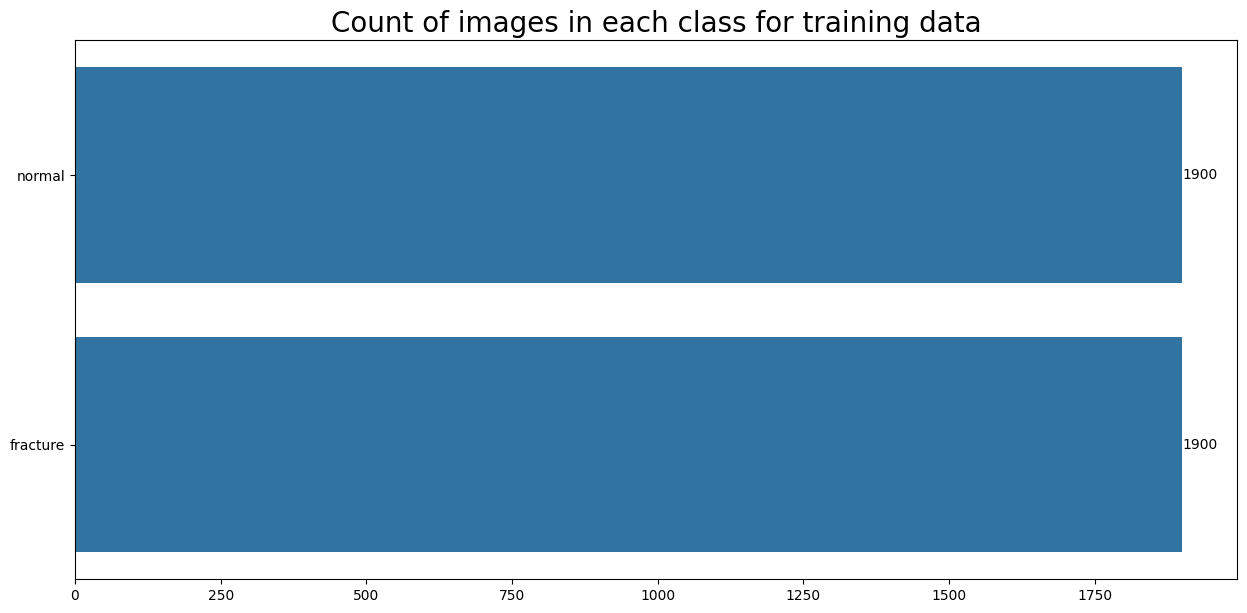

In [8]:
# Display count of images in each class for training data
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=tr_df, y=tr_df['Class'])
plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class for training data', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

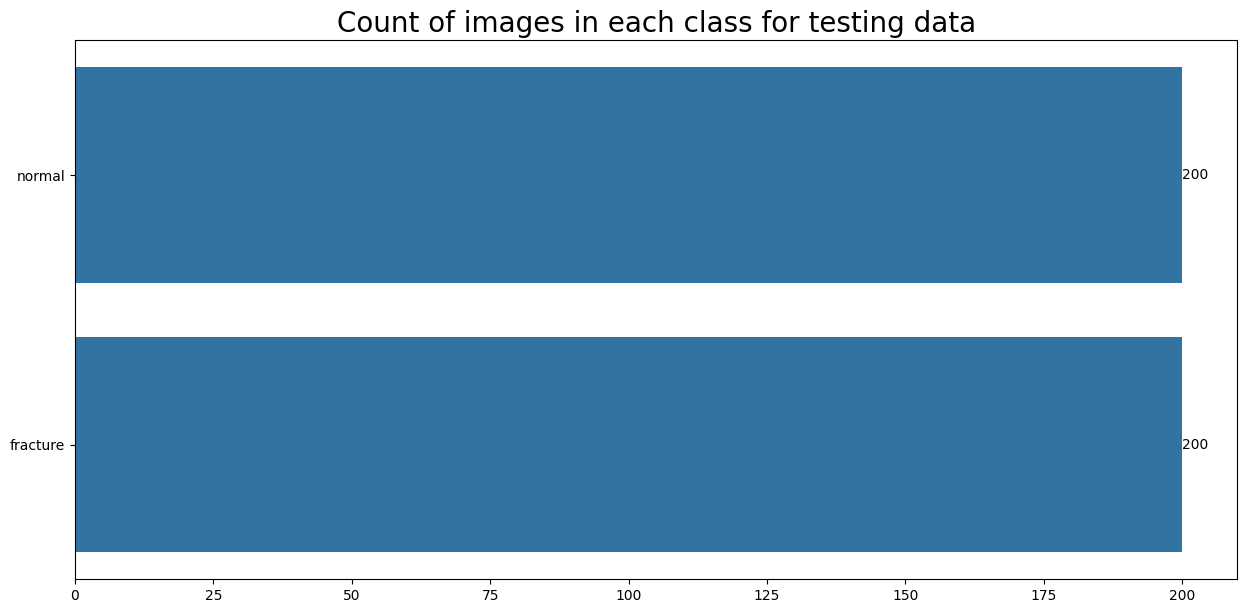

In [9]:
# Display count of images in each class for testing data
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=ts_df, y=ts_df['Class'])
plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class for testing data', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [10]:
# Split testing data into validation and test sets
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20)

In [11]:
valid_df

,Class Path,Class
345,cervical_fracture/val/fracture/CSFDV1B10 (16)-...,fracture
399,cervical_fracture/val/fracture/CSFDV1B10 (15)-...,fracture
330,cervical_fracture/val/fracture/CSFDV1B10 (10)-...,fracture
238,cervical_fracture/val/fracture/CSFDV1B10 (14)-...,fracture
293,cervical_fracture/val/fracture/CSFDV1B10 (15)-...,fracture
...,...,...
393,cervical_fracture/val/fracture/CSFDV1B10 (10)-...,fracture
218,cervical_fracture/val/fracture/CSFDV1B10 (16)-...,fracture
223,cervical_fracture/val/fracture/CSFDV1B10 (14)-...,fracture
271,cervical_fracture/val/fracture/CSFDV1B10 (17)-...,fracture


In [12]:
# Define batch size and image size
batch_size = 16
img_size = (299, 299)

# Define transformations for train, validation, and test data
transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

transform_val_test = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
])

In [13]:
# Create datasets and dataloaders for train, validation, and test data
train_data = ImageFolder(root=tr_path, transform=transform_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

valid_data = ImageFolder(root=ts_path, transform=transform_val_test)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

test_data = ImageFolder(root=ts_path, transform=transform_val_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [14]:
ts_path

'cervical_fracture/val'

In [15]:
valid_loader

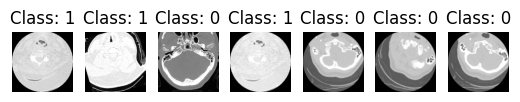

In [16]:
import matplotlib.pyplot as plt

# Define the number of images to display
num_images = 7

# Iterate over the training DataLoader to get some images
for batch_idx, (images, labels) in enumerate(train_loader):
    # Display images from the first batch
    if batch_idx == 0:
        # Iterate over the images in the batch
        for i in range(num_images):
            # Get the ith image and its label
            image = images[i].permute(1, 2, 0)  # Permute dimensions to (height, width, channels)
            label = labels[i].item()

            # Plot the image
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image)
            plt.title(f'Class: {label}')
            plt.axis('off')  # Turn off axis
        plt.show()
        break  # Break after displaying the first batch of images


In [17]:
# Define device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class MobileNet(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, groups=32),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, groups=128),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, groups=256),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1, groups=512),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1024, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, groups=1024),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.2),
            nn.Conv2d(1024, num_classes, kernel_size=1, stride=1, padding=0),
            nn.Flatten(),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [18]:
# Instantiate the model and move it to the appropriate device
model = MobileNet().to(device)

In [19]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [20]:
# Training the model
num_epochs = 30
best_valid_loss = float('inf')
last_improvement = 0
patience = 3
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_running_loss += loss.item() * images.size(0)

    valid_epoch_loss = valid_running_loss / len(valid_loader.dataset)
    valid_losses.append(valid_epoch_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Valid Loss: {valid_epoch_loss:.4f}')

    # Early stopping
    if valid_epoch_loss < best_valid_loss:
        best_valid_loss = valid_epoch_loss
        last_improvement = epoch
    else:
        if epoch - last_improvement > patience:
            print("Early stopping!")
            break

Epoch 1/30, Train Loss: 0.4797, Valid Loss: 0.6379
Epoch 2/30, Train Loss: 0.4192, Valid Loss: 0.3293
Epoch 3/30, Train Loss: 0.3825, Valid Loss: 0.3179
Epoch 4/30, Train Loss: 0.3414, Valid Loss: 0.3144
Epoch 5/30, Train Loss: 0.3254, Valid Loss: 0.3136
Epoch 6/30, Train Loss: 0.3237, Valid Loss: 0.3139
Epoch 7/30, Train Loss: 0.3201, Valid Loss: 0.3134
Epoch 8/30, Train Loss: 0.3194, Valid Loss: 0.3137
Epoch 9/30, Train Loss: 0.3194, Valid Loss: 0.3137
Epoch 10/30, Train Loss: 0.3160, Valid Loss: 0.3133
Epoch 11/30, Train Loss: 0.3154, Valid Loss: 0.3142
Epoch 12/30, Train Loss: 0.3161, Valid Loss: 0.3143
Epoch 13/30, Train Loss: 0.3192, Valid Loss: 0.3143
Epoch 14/30, Train Loss: 0.3152, Valid Loss: 0.3139
Early stopping!


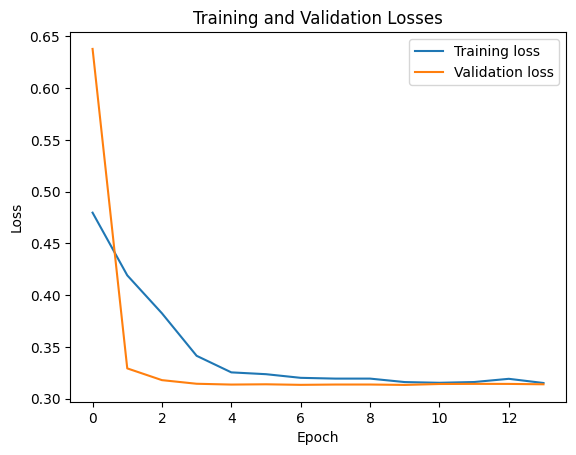

In [21]:
# Plotting training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [22]:
# Classification report
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



In [23]:
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


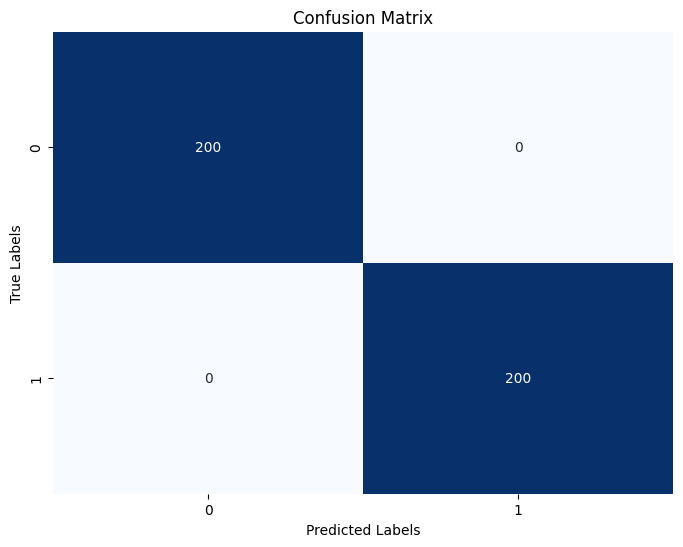

In [24]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()